In [7]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import glob
import os
import ast
from tqdm.contrib.itertools import product

In [8]:
directory_path = "../experiment/"

# Get all CSV file names in the directory
csv_files = [file for file in os.listdir(directory_path) if file.endswith(".csv")]
dataframes = []
for file in csv_files:
    file_path = os.path.join(directory_path, file)
    df = pd.read_csv(file_path)
    dataframes.append(df)
df = pd.concat(dataframes, ignore_index=True)


In [9]:
df_metric = pd.read_csv('../experiment/metrics/metrics_6m_12s.csv')
metrics = []
for i in range(len(df_metric["metric"])):
    metrics.append(ast.literal_eval(df_metric['metric'][i]))
data = np.round(np.array(metrics).flatten())

metric_dict = {}
index = 0
for map_id in range(5):
    for (agent_num, agent_vel) in product([10, 20, 30], [20, 40, 60]):
        metric_dict[(map_id, agent_num, agent_vel)] = data[index]
        index += 1

df['map difficulty'] = df.apply(lambda row: metric_dict.get((row['Map ID'], row['Number of agents'], row['Agent speed']), 'N/A'), axis=1)

# Convert string representation of tuple to actual tuple
df['Initial position'] = df['Initial position'].apply(ast.literal_eval)


100%|██████████| 9/9 [00:00<00:00, 102023.61it/s]


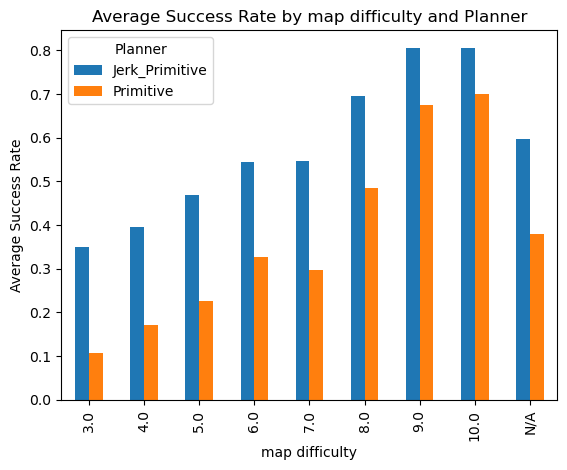

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Define your labels
label1 = 'map difficulty'  # replace with your chosen label
label2 = 'Planner'  # replace with your chosen label

# Group by label1 and label2, then calculate success rate
grouped = df.groupby([label1, label2])['Success'].mean().reset_index()

# Pivot the data for easier plotting
pivot_df = grouped.pivot(index=label1, columns=label2, values='Success')

# Plot
pivot_df.plot(kind='bar')

# Set labels and title
plt.xlabel(label1)
plt.ylabel('Average Success Rate')
plt.title('Average Success Rate by {} and {}'.format(label1, label2))

# Show the plot
plt.show()


In [11]:
gaze_methods = ['NoControl', 'LookAhead', 'Owl', 'LookGoal', 'Oxford']
planners = ['Primitive', 'Jerk_Primitive', 'MPC']
agent_numbers = [10, 20, 30]
pillar_numbers = [0]
agent_max_speeds = [20, 40, 60]
drone_max_speeds = [20, 40, 60]
depth_vars = [0, 2]

In [12]:
import pandas as pd
import itertools

column_names = [
    'Method',
    'Planner',
    'depth var',
    'Number of agents',
    'Number of pillars',
    'Agent speed',
    'Drone speed',
    'Depth variance',
    'Total samples',
    'Success',
    'Static Collision',
    'Dynamic Collision',
    'Dead Lock',
    'Success rate',
    'Tracked agents',
    'Tracked time'
]

result_df = pd.DataFrame([], columns=column_names)

# Generate all possible combinations of loop variables
combinations = itertools.product(
    gaze_methods,
    agent_numbers,
    pillar_numbers,
    drone_max_speeds,
    agent_max_speeds,
    planners,
    depth_vars
)

# Iterate over combinations
for combination in combinations:
    (
        gaze_method,
        agent_number,
        pillar_number,
        drone_speed,
        agent_speed,
        planner,
        depth_var
    ) = combination

    df_i = df[
        (df['Method'] == gaze_method) &
        (df['Planner'] == planner) &
        (df['Number of agents'] == agent_number) &
        (df['Number of pillars'] == pillar_number) &
        (df['Agent speed'] == agent_speed) &
        (df['Drone speed'] == drone_speed) &
        (df['Depth variance'] == depth_var)
    ].copy(deep=True)

    if df_i.shape[0] != 0:
        result_df.loc[len(result_df)] = [
            gaze_method,
            planner,
            depth_var,
            agent_number,
            pillar_number,
            agent_speed,
            df_i['Drone speed'].sum() / df_i.shape[0],
            depth_var,
            df_i.shape[0],  # total samples
            df_i['Success'].sum(),
            df_i['Static Collision'].sum(),
            df_i['Dynamic Collision'].sum(),
            df_i['Dead Lock'].sum(),
            (df_i['Success'].sum() + df_i['Dead Lock'].sum()) / df_i.shape[0],  # Success rate
            df_i['Agent tracked'].sum(),
            (df_i['Agent tracked time'] * df_i['Agent tracked']).sum()
        ]


In [14]:

# result_df['Success rate'] = result_df['Success'] / result_df['Total samples']
result_df['velocity ratio'] = (result_df['Agent speed'] / result_df['Drone speed']).round(2)
# result_df['map_difficulty'] = metric_dict[(result_df['Map'])]
result_df.to_csv('./post.csv')                            

/tmp/ipykernel_19131/701669911.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_single = df[result_df[x_label] == x_value]


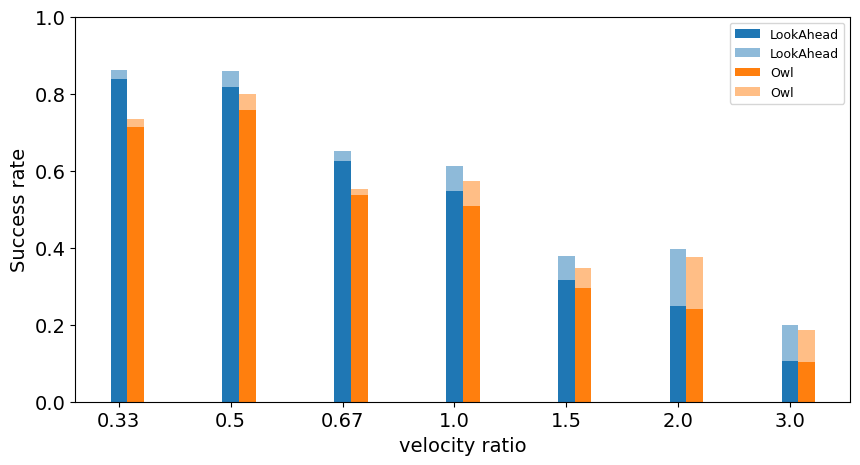

In [16]:
import matplotlib as mpl
plt.rcParams['figure.figsize'] = [10, 5]
fig, ax = plt.subplots()
width = 0.15
x_label = 'velocity ratio'
legend = 'Method'

x_values = (result_df[x_label].unique())
x_values.sort()
labels = result_df[legend].unique()

cmap = mpl.cm.get_cmap("viridis", len(labels))
colors = cmap(np.linspace(0, 1, len(labels)))

for i, label in enumerate(labels):
    
    df = result_df[result_df[legend] == label]
    y_values = []
    dead_locks = []
    rects = []

    for x_value in x_values:
        df_single = df[result_df[x_label] == x_value]
        y_values.append((df_single['Success'].sum()) / df_single['Total samples'].sum())
        dead_locks.append((df_single['Dead Lock'].sum()) / df_single['Total samples'].sum())
    
    rects.append(ax.bar(np.arange(len(x_values)) + i*width, y_values, width, color=plt.cm.tab20(2*i), label=label))
    rects.append(ax.bar(np.arange(len(x_values)) + i*width, dead_locks, width, color=tuple(map(sum, zip(plt.cm.tab20(2*i), (0, 0, 0, -0.5)))), label=label, bottom=y_values))

plt.xticks(range(x_values.shape[0]), x_values)
plt.xlabel(x_label)
plt.ylabel("Success rate")
plt.legend(fontsize=9)
plt.rcParams.update({'font.size': 14})
plt.ylim(0, 1)
# plt.savefig('../../resources/vel_ratio.pdf')
plt.show()

No handles with labels found to put in legend.


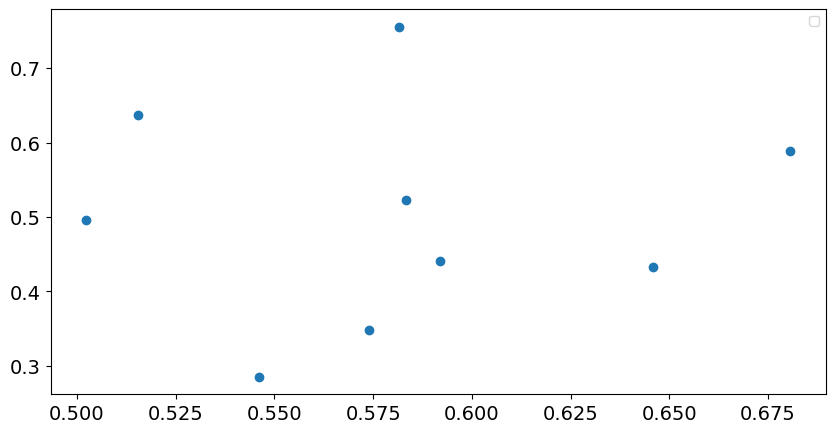

In [ ]:
import matplotlib as mpl
plt.rcParams['figure.figsize'] = [10, 5]
fig, ax = plt.subplots()
width = 0.15
legend = 'Method'
legend2 = 'Planner'

labels = result_df[legend].unique()
labels2 = result_df[legend2].unique()

cmap = mpl.cm.get_cmap("viridis", len(labels))
colors = cmap(np.linspace(0, 1, len(labels)))

x_values = []
y_values = []

for i, label in enumerate(labels):
    for j, label2 in enumerate(labels2):
    
        df_single = result_df[(result_df[legend] == label) &
                       (result_df[legend2] == label2)]
        x_values.append(df_single['Success'].sum() / df_single['Total samples'].sum())
        y_values.append((df_single['Tracked time'].sum()) / df_single['Tracked agents'].sum() / 10)


plt.scatter(y_values, x_values)
plt.legend(fontsize=9)
plt.rcParams.update({'font.size': 14})
# plt.ylim(0, 1)
# plt.savefig('../../resources/vel_ratio.pdf')
plt.show()

/tmp/ipykernel_10856/2592096932.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_single = df[result_df[x_label] == x_value]


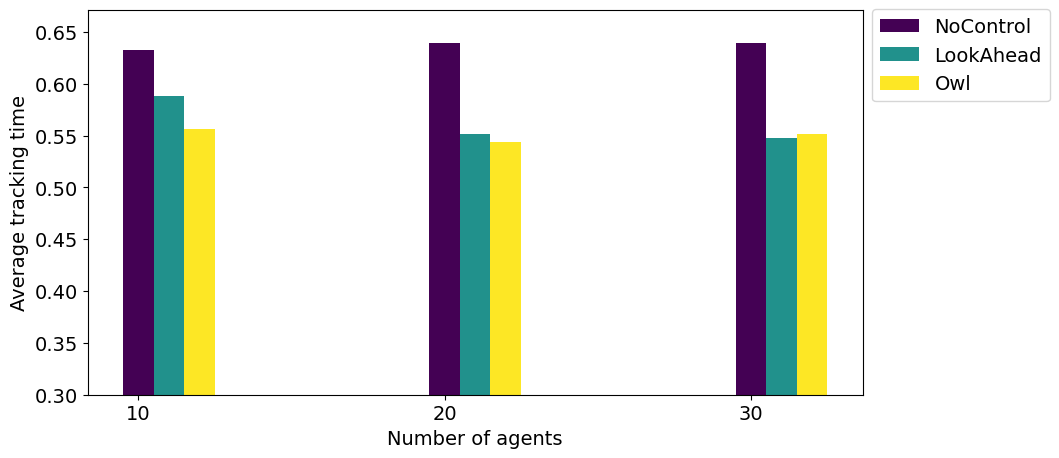

In [ ]:
import matplotlib as mpl
plt.rcParams['figure.figsize'] = [10, 5]
fig, ax = plt.subplots()
width = 0.1
x_label = 'Number of agents'
legend = 'Method'

x_values = (result_df[x_label].unique())
x_values.sort()
labels = result_df[legend].unique()

cmap = mpl.cm.get_cmap("viridis", len(labels))
colors = cmap(np.linspace(0, 1, len(labels)))

for i, label in enumerate(labels):
    
    df = result_df[result_df[legend] == label]
    y_values = []
    rects = []

    for x_value in x_values:
        df_single = df[result_df[x_label] == x_value]
        y_values.append((df_single['Tracked time'].sum()) / df_single['Tracked agents'].sum() / 10)
    
    rects.append(ax.bar(np.arange(len(x_values)) + i*width, y_values, width, color=colors[i], label=label))

plt.xticks(range(x_values.shape[0]), x_values)
plt.xlabel(x_label)
plt.ylabel("Average tracking time")
plt.ylim(bottom=0.3)
plt.legend(bbox_to_anchor=(0.9,0.9), bbox_transform=plt.gcf().transFigure)    
# plt.savefig('../../resources/tracking_time.pdf', bbox_inches="tight")
plt.show()